# Naive Bayes

Naive Bayes is a simple and powerful algorithm for classification. It is based on Bayes' theorem, which is a fundamental theorem in probability theory. The naive assumption is that the features are conditionally independent given the class label. This assumption simplifies the computation of the likelihoods and makes the algorithm very efficient.

In this notebook, we will implement a Naive Bayes classifier from scratch and apply it to the breast cancer and wine datasets.

### Bayes theorem

Bayes theorem states that the probability of a event $A$ given the event $B$ has occurred is:

$$
P(A|B) = \frac{P(B|A) \space P(A)}{P(B)}
$$

### Naive Bayes

In the context of classification, the event $A$ is the class label $y$ and the event $B$ is the feature vector $X$. The goal is to find the most probable class label given the feature vector:

$$
P(y|X) = \frac{P(X|y) \space P(y)}{P(X)}
$$

The naive assumption is that the features are conditionally independent of each other given the class label:

$$
P(x|y) = \prod_{i=1}^n P(x_i|y)
$$

where $x_i$ are the features of the feature vector $x$. This means that the likelihood of the feature vector $x$ given the class label $y$ is the product of the likelihoods of each feature given the class label.

$$
P(y|X) = \frac{P(x_1|y) \space P(x_2|y) \space ... \space P(x_n|y) \space P(y)}{P(X)} = \frac{P(y) \prod_{i=1}^n P(x_i|y)}{P(X)}
$$

Here 
- $P(y|X)$ is the posterior probability of class $y$ given the feature vector $X$
- $P(y)$ is the prior probability of class $y$
- $P(x_i|y)$ is called class conditional probability
- $P(X)$ is the evidence

### Derivation

$$
P(y|x_1, x_2, ..., x_n) = \frac{P(y) \prod_{i=1}^n P(x_i|y)}{P(x_1, x_2, ..., x_n)}
$$

Since $P(x_1, x_2, ..., x_n)$ is constant for all classes, we can ignore it:

$$
P(y|x_1, x_2, ..., x_n) \propto P(y) \prod_{i=1}^n P(x_i|y)
$$

$$
\hat{y} = \arg\max_y P(y|x_1, x_2, ..., x_n) = \arg\max_y \left( P(y) \prod_{i=1}^n P(x_i|y) \right)
$$

Since the probabilities can be very small, their product can be very close to zero. To avoid numerical underflow, we can take the logarithm of the probabilities:

$$
\hat{y} = \arg\max_y \left( \log P(y) + \sum_{i=1}^n \log P(x_i|y) \right)  
$$

since the logarithm is a monotonic function, the class label that maximizes the log probability also maximizes the probability. Also $log(a \cdot b) = log(a) + log(b)$.

For continuous features, we can assume that the likelihoods are normally distributed:

$$
P(x_i|y) = \frac{1}{\sqrt{2\pi\sigma_y^2}} \exp\left(-\frac{(x_i - \mu_y)^2}{2\sigma_y^2}\right)
$$

where
- $\mu_y$ is the mean of feature $x_i$ in class $y$
- $\sigma_y$ is the standard deviation of feature $x_i$ in class $y$

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
def gaussian_probability(x, mean, std):
    exponent = math.exp(-(math.pow(x-mean,2)/(2*math.pow(std,2))))
    return (1 / (math.sqrt(2*math.pi) * std)) * exponent

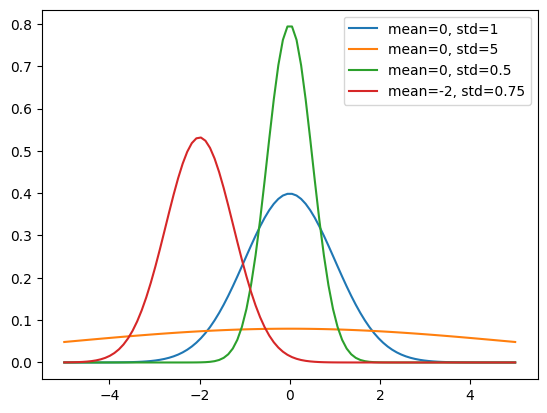

In [3]:
# plot guassian distribution

mean_std_pairs = [(0, 1), (0, 5), (0, .5), (-2, .75)]

for mean, std in mean_std_pairs:
    x = np.linspace(-5, 5, 100)
    y = [gaussian_probability(i, mean, std) for i in x]
    sns.lineplot(x=x, y=y, label=f'mean={mean}, std={std}')
plt.legend()
plt.show()

### Datasets

In [4]:
from sklearn.datasets import load_wine, load_breast_cancer

# multi class classification
wine = load_wine()
# binary classification
breast_cancer = load_breast_cancer()

In [5]:
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df['target'] = wine.target
df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


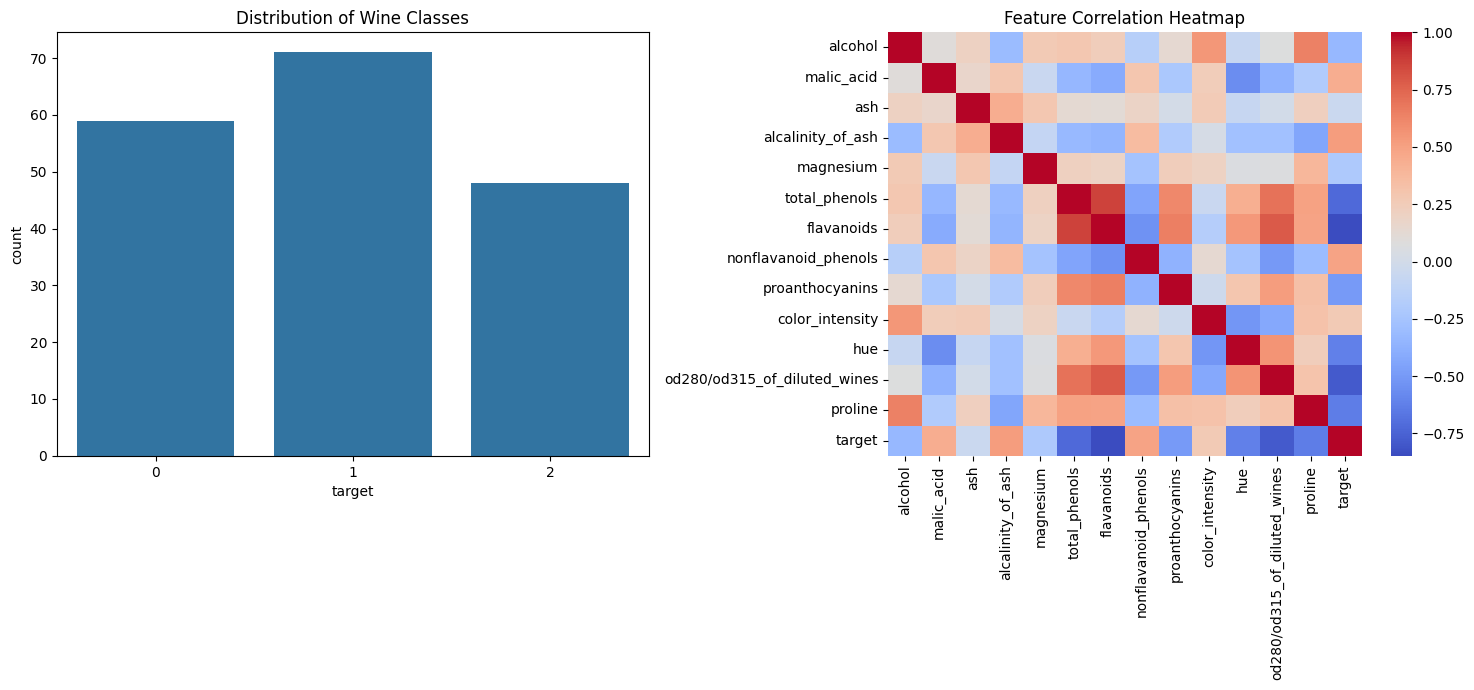

In [6]:
# Create a figure with multiple subplots
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)

sns.countplot(x='target', data=df)
plt.title('Distribution of Wine Classes')

# Correlation heatmap
plt.subplot(1, 2, 2)
correlation = df.corr()
sns.heatmap(correlation, cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')

plt.tight_layout()
plt.show()

In [7]:
df = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
df['target'] = breast_cancer.target
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


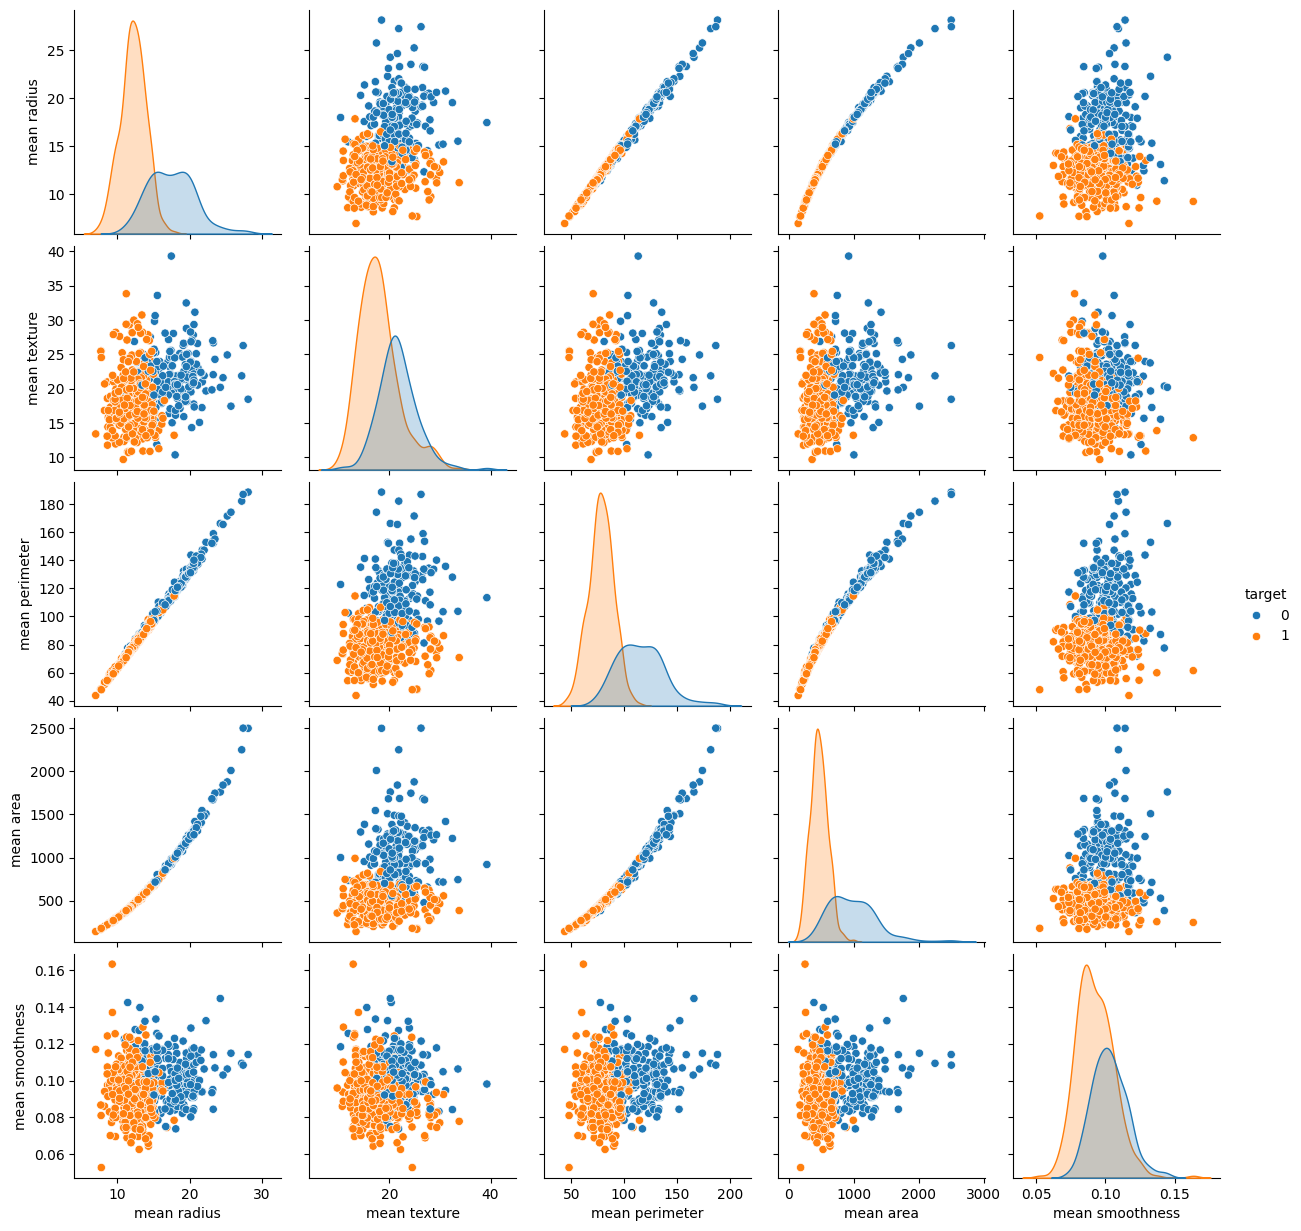

In [8]:
sns.pairplot(df, hue='target', vars=['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness'])
plt.show()

### SKlearn

In [9]:
from sklearn.metrics import classification_report

def train_and_evaluate(model, X, y, test_size=0.2, random_state=1337):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred)
    return accuracy, report

In [10]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()

accuracy, report = train_and_evaluate(model, wine.data, wine.target)
print('Wine Dataset')
print('Accuracy:', accuracy)
print('Classification Report:')
print(report)

# For breast cancer dataset
accuracy, report = train_and_evaluate(model, breast_cancer.data, breast_cancer.target)
print('Breast Cancer Dataset')
print('Accuracy:', accuracy)
print('Classification Report:')
print(report)

Wine Dataset
Accuracy: 0.8888888888888888
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        18
           1       0.80      0.92      0.86        13
           2       0.83      1.00      0.91         5

    accuracy                           0.89        36
   macro avg       0.88      0.92      0.89        36
weighted avg       0.90      0.89      0.89        36

Breast Cancer Dataset
Accuracy: 0.9298245614035088
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90        41
           1       0.92      0.97      0.95        73

    accuracy                           0.93       114
   macro avg       0.93      0.91      0.92       114
weighted avg       0.93      0.93      0.93       114



### Implementation


We will implement the following methods in the `NaiveBayes` class:
- `fit(X, y)`: Fit the model to the training data
- `predict(X)`: Predict the class labels for the test data
- `predict_proba(X)`: Predict the probabilities of the class labels for the test data

In [11]:
class NaiveBayes:

    def __init__(self, eps=1e-10):
        self.eps = eps

    def _gaussian_probability(self, x, mean, var):
        # Using vectorized numpy operations instead of math
        exponent = -((x - mean) ** 2 / (2 * var))
        return 1 / np.sqrt(2 * np.pi * var) * np.exp(exponent)

    def fit(self, X, y):
        n_samples, n_features = X.shape
        # get all unique classes
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        # calculate mean, var, and prior for each class

        # mean of each feature for each class
        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        # variance of each feature for each class
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        # prior probability of each class before seeing any features
        self._priors = np.zeros(n_classes, dtype=np.float64)

        # calculate mean, var, and prior for each class
        for idx, c in enumerate(self._classes):
            # get all features where the class is c
            X_c = X[y == c]
            # calculate mean for each feature along column (axis=0)
            self._mean[idx, :] = X_c.mean(axis=0)
            # calculate variance for each feature along column (axis=0)
            self._var[idx, :] = X_c.var(axis=0)
            # calculate prior probability of each class
            # X_c.shape[0] is the number of samples in class c
            # n_samples is the total number of samples
            self._priors[idx] = X_c.shape[0] / float(n_samples)

        # these values will be used in the predict method
        # based on the naive bayes formula

    def _posteriors(self, x):
        # y = argmax(log(P(y)) + log(P(x1|y)) + log(P(x2|y)) + ... + log(P(xn|y)))
        posteriors = []

        for idx, c in enumerate(self._classes):
            # calculate the prior probability of class c -> log(P(y))
            prior = np.log(self._priors[idx])
            # mean and variance of class c for each feature
            mean = self._mean[idx]
            var = self._var[idx]
            # calculate the class conditional probability -> log(P(x1|y)) + log(P(x2|y)) + ... + log(P(xn|y))
            probs = self._gaussian_probability(x, mean, var)
            class_conditional = np.sum(np.log(np.maximum(probs, self.eps)))
            # calculate the posterior probability
            posterior = prior + class_conditional
            posteriors.append(posterior)
        return posteriors

    def predict(self, X):
        posteriors = [self._posteriors(x) for x in X]
        # get the class with the highest posterior probability
        y_pred = self._classes[np.argmax(posteriors, axis=1)]
        return y_pred

    def predict_proba(self, X):
        posteriors = [self._posteriors(x) for x in X]
        return posteriors

    def score(self, X, y):
        y_pred = self.predict(X)
        accuracy = np.mean(y_pred == y)
        return accuracy

In [12]:
model = NaiveBayes()

accuracy, report = train_and_evaluate(model, wine.data, wine.target)
print('Wine Dataset')
print('Accuracy:', accuracy)
print('Classification Report:')
print(report)

# For breast cancer dataset
accuracy, report = train_and_evaluate(model, breast_cancer.data, breast_cancer.target)
print('Breast Cancer Dataset')
print('Accuracy:', accuracy)
print('Classification Report:')
print(report)

Wine Dataset
Accuracy: 0.8888888888888888
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        18
           1       0.80      0.92      0.86        13
           2       0.83      1.00      0.91         5

    accuracy                           0.89        36
   macro avg       0.88      0.92      0.89        36
weighted avg       0.90      0.89      0.89        36

Breast Cancer Dataset
Accuracy: 0.9122807017543859
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.85      0.88        41
           1       0.92      0.95      0.93        73

    accuracy                           0.91       114
   macro avg       0.91      0.90      0.90       114
weighted avg       0.91      0.91      0.91       114



# Conclusion

In this notebook, we implemented a Naive Bayes classifier from scratch and applied it to the breast cancer and wine datasets. We also show cased how our simple implementation compares to the one in sklearn.